In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ddpm import *
import utils


/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# test loader
cl_train_loaders, cl_test_loaders, train_loader, test_loader = utils.get_cl_dataset('mnist', batch_size=128, normalize=True)

Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:07<00:00, 7908.77it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 7850.38it/s]


In [7]:
# 1. Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 1e-4
num_epochs = 10
num_timesteps = 1000

In [6]:
# instantiate scheduler and UNet
scheduler = NoiseScheduler(timesteps=1000, device=device)
unet = UNet2DModel(
    sample_size=28,         
    in_channels=1 + 4,
    out_channels=1,
    block_out_channels=(32, 64, 64),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    # norm_num_groups=32
)
ddpm = DDPM(unet=unet, scheduler=scheduler,n_classes=10, device=device)

NameError: name 'device' is not defined

Epoch 1/10: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s, loss=0.0316]


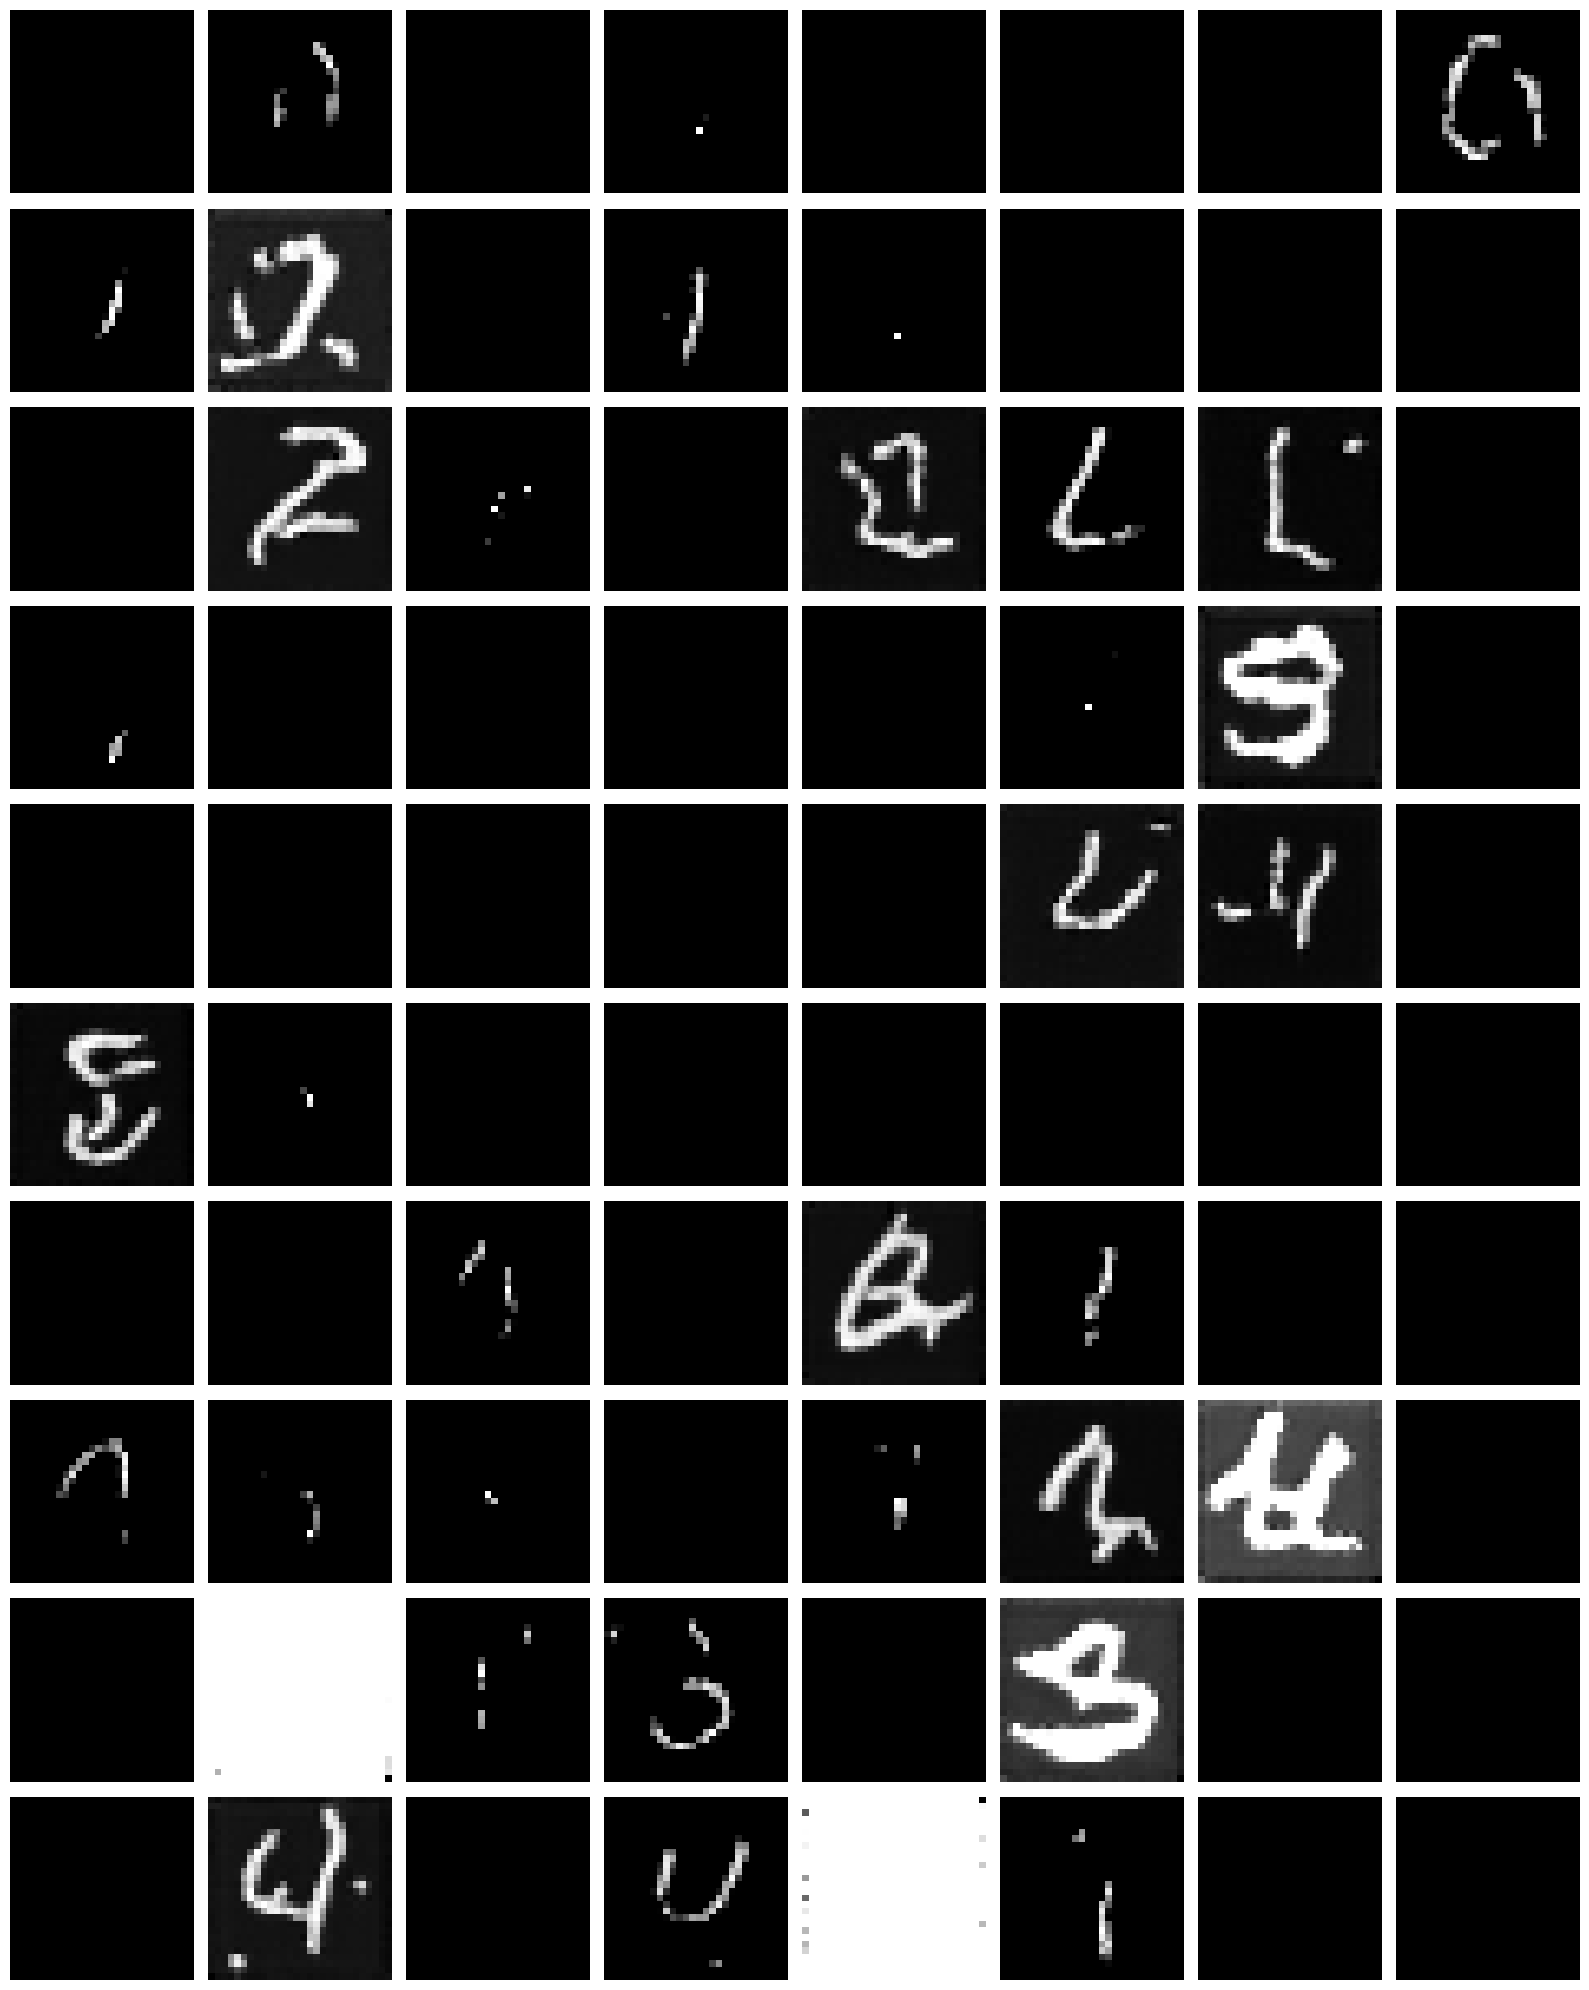

Epoch 2/10:  45%|████▍     | 210/469 [00:12<00:14, 17.47it/s, loss=0.0286]


KeyboardInterrupt: 

In [13]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
num_epochs = 10
step = 0

for epoch in range(1, num_epochs+1):
    ddpm.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    avg_loss = 0.0
    for imgs, label in pbar:
        imgs = imgs.to(device)
        label = label.to(device)
        # t = torch.randint(0, ddpm.scheduler.timesteps, (batch_size,), device=device).long()


        pred_noise, noise = ddpm(imgs, y=label)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = avg_loss * 0.9 + loss.item() * 0.1
        pbar.set_postfix(loss=avg_loss)
        step += 1
        # optional: save a checkpoint every few epochs
# if step % 1000 == 0:
    # 5) Sampling example
    ddpm.eval()
    samples = ddpm.sample(
        num_samples_per_label=8,
        image_dim=(1, 28, 28),
        condition=torch.arange(0, 10).to(device)
    ).view(10, 8, 1, 28, 28)
    # print(samples.shape)
    # display samples in num_samples_per_label by len(condition) grid
    fig, axes = plt.subplots(10,
                    8,
                    figsize=(8 * 2, 10 * 2),
                    squeeze=False)

    for i in range(10):
        for j in range(8):
            img = samples[i, j].cpu().permute(1, 2, 0) * 0.5 + 0.5  # (H, W, C)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    ddpm.train()

# CL experiments

In [6]:
# instantiate scheduler and UNet
scheduler = NoiseScheduler(timesteps=1000, device=device)
unet = UNet2DModel(
    sample_size=32,         
    in_channels=3,
    out_channels=3,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    norm_num_groups=32
)
ddpm = DDPM(unet=unet, scheduler=scheduler, n_classes=0, device=device, condition_dim=1)

In [12]:
# If doing MNIST
scheduler = NoiseScheduler(timesteps=1000, device=device)
unet = UNet2DModel(
    sample_size=28,         
    in_channels=1,
    out_channels=1,
    block_out_channels=(32, 64, 64),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    # norm_num_groups=32
)
ddpm = DDPM(unet=unet, scheduler=scheduler, n_classes=0, device=device, condition_dim=1)
image_dim = (1, 28, 28)

In [ ]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=2e-4)
num_epochs = 100
step = 0

ewc_history = []          # list of EWC objects, one per *finished* class/task
reg_weigth = 1e10

for class_id, loader in cl_train_loaders.items():
    for epoch in tqdm(range(1, num_epochs+1)):
        ddpm.train()
        pbar = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")
        # avg_loss = 0.0
        for imgs, label in pbar:
            imgs = imgs.to(device)
            label = label.to(device)
            label = None
            # t = torch.randint(0, ddpm.scheduler.timesteps, (batch_size,), device=device).long()


            pred_noise, noise = ddpm(imgs, y=label)
            loss = F.mse_loss(pred_noise, noise)

            # ---------- EWC regularisation ----------
            reg_term = torch.zeros(1, device=device)
            if ewc_history:                               # skip for very first task
                reg_term = sum(e.penalty(ddpm) for e in ewc_history)
                loss = loss + reg_term * reg_weigth  # scale the EWC term


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # avg_loss = avg_loss * 0.9 + loss.item() * 0.1
            # pbar.set_postfix(loss=avg_loss)
            # pbar set postfix with loss and reg_term
            pbar.set_postfix(loss=loss.item(), reg_term=reg_term.item() * reg_weigth)
            step += 1
            # optional: save a checkpoint every few epochs

    ewc_history.append(utils.EWC(ddpm, loader, device))

    # 5) Sampling example
    ddpm.eval()
    samples = ddpm.sample(
        num_samples_per_label=80,
        image_dim=image_dim,
        condition=None#torch.arange(0, 10).to(device)
    ).view(10, 8, *image_dim)
    # print(samples.shape)
    # display samples in num_samples_per_label by len(condition) grid
    fig, axes = plt.subplots(10,
                    8,
                    figsize=(8 * 2, 10 * 2),
                    squeeze=False)

    for i in range(10):
        for j in range(8):
            img = samples[i, j].cpu().permute(1, 2, 0) * 0.5 + 0.5  # (H, W, C)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    ddpm.train()

100%|██████████| 100/100 [04:46<00:00,  2.87s/it]
